In [1]:
import pandas as pd
import numpy as np
import shap
import argparse

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
def read_any(file, header):
    if file.endswith('.csv') or file.endswith('.tsv'):
        if header:
            df = pd.read_csv(file, header=0)
        else:
            df = pd.read_csv(file)
    elif file.endswith('.json'):
        df = pd.read_json(file)
    elif file.endswith('.xml'):
        df = pd.read_xml(file)
    elif file.endswith('.xls') or file.endswith('.xlsx'):
        df = pd.read_excel(file)
    elif file.endswith('.hdf'):
        df = pd.read_hdf(file)
    elif file.endswith('.sql'):
        df = pd.read_sql(file)
    else:
        raise ValueError(f'Unsupported filetype: {file}')
    return df

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('data', help='path to the file with dataset')
parser.add_argument('target', help='index of the target column', type=int)
parser.add_argument('--header', action='store_true')

args = parser.parse_args(['diabetes_binary_health_indicators_BRFSS2021.csv', '0', '--header'])

In [4]:
data = read_any(args.data, args.header)
target_idx = args.target
target = data.iloc[:, target_idx]
data = data.drop(columns=data.columns[target_idx])

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

In [5]:
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

In [ ]:
model_params = {
    'eval_metric': 'F1',
    'custom_metric': ['Accuracy', 'Precision', 'Recall'],
}

grid_params = {
    'iterations': np.linspace(1000, 3000, 3, dtype=int),
    'learning_rate': np.logspace(-2, 0.5, 4),
    'l2_leaf_reg': np.logspace(-2, 1, 4)
}

model = CatBoostClassifier(**model_params)
params, cv_results = model.grid_search(grid_params, train_pool, plot=True, verbose=False)

In [6]:
params = {'iterations': 1000, 'learning_rate': 0.2}

In [ ]:
final_model = CatBoostClassifier(**model_params, **params)
final_model.fit(train_pool, eval_set=test_pool)

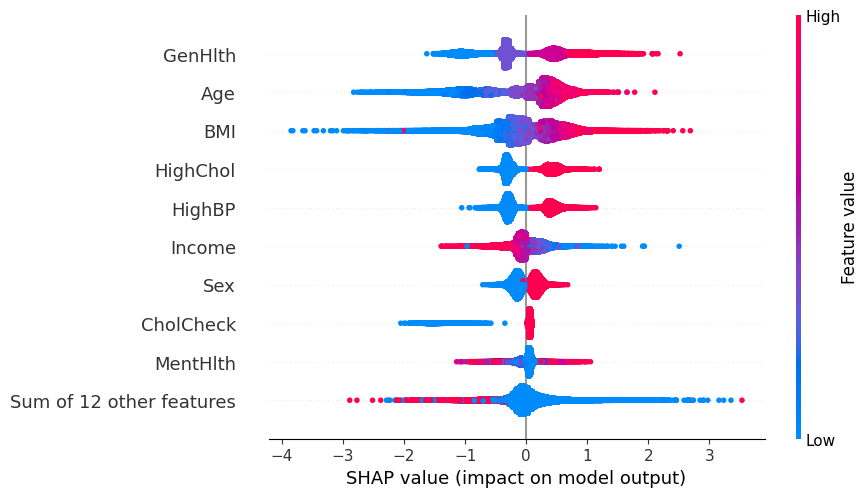

In [15]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(data)

shap.plots.beeswarm(shap_values)